<div style="">
    <img src="images/emlyon.png" style="height:60px; float:left; padding-right:10px;" />
    <span style="display:inline-block; floa:left; width:500px;  padding-left:10px;">
        <h1 style=" display:table-cell; padding-bottom:3px;"> Smart Supply Chain </h1>
        <a style="" href="https://masters.em-lyon.com/fr/msc-in-data-science-artificial-intelligence-strategy">[Emlyon]</a> MSc in Data Science & Artificial Intelligence Strategy (DSAIS) <br/>
          Paris | © Saeed VARASTEH
    </span>
</div>

### Part 05 - Exercises 02 : The Forecast Competition

---
<img src="images/competition.png" style="width:100px; position:absolute; top:-10px; right:0;"/>

__Objective__: Predict three months of item sales at different stores.

__Dataset description__

You are given a file named `store_sales.csv`:

    date - Date
    store - Store ID
    item - Item ID
    sales - Number of items sold at a particular store on a particular date.
    


### Import data and modules

#### Import modules

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

#### Import data

In [19]:
sales = pd.read_csv('./data/store/store_sales.csv')
print(sales.shape)
sales.head(5)

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


## <span style="color:steelblue;">  Data Exploration  </span>


#### The data in the sales dataset are from which period?

__Hint:__ find the minimum and the maximum of the date.<br/>
__Hint:__ do not forget to convert the `date` column into datetime.

In [20]:
# YOUR CODE
sales['date'] = pd.to_datetime(sales['date'], format='%Y-%m-%d')
sales.head(5)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [21]:
# Find the minimum and maximum dates
min_date = sales['date'].min()
max_date = sales['date'].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")

Minimum date: 2013-01-01 00:00:00
Maximum date: 2017-12-31 00:00:00


#### How many unique items and stores are in the dataset?

In [22]:
# YOUR CODE
# Number of unique items
unique_items = sales['item'].nunique()  # Replace 'item_column' with the actual column name for items

# Number of unique stores
unique_stores = sales['store'].nunique()  # Replace 'store_column' with the actual column name for stores

print(f"Number of unique items: {unique_items}")
print(f"Number of unique stores: {unique_stores}")


Number of unique items: 50
Number of unique stores: 10


#### Plot average monthly sales for the item_id == 10 at store_id == 1

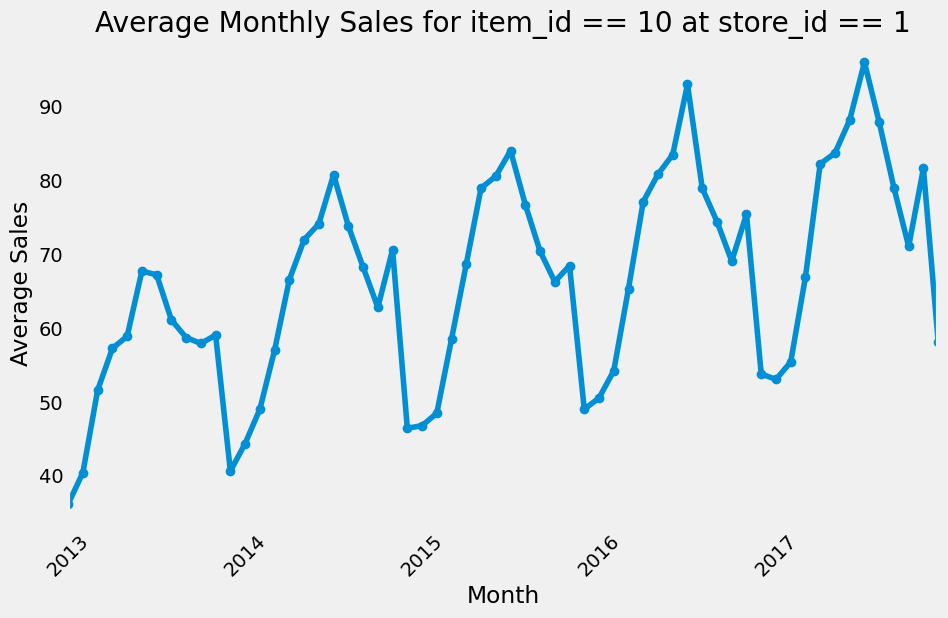

In [23]:
# YOUR CODE
import pandas as pd
import matplotlib.pyplot as plt

# Filter for item_id == 10 and store_id == 1
filtered_data = sales[(sales['item'] == 10) & (sales['store'] == 1)]

# Ensure the date column is in datetime format
filtered_data['date'] = pd.to_datetime(filtered_data['date'])

# Add a month column for grouping
filtered_data['month'] = filtered_data['date'].dt.to_period('M')

# Group by month and calculate average sales
monthly_sales = filtered_data.groupby('month')['sales'].mean()

# Plot the average monthly sales
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='line', marker='o')
plt.title('Average Monthly Sales for item_id == 10 at store_id == 1')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.grid()
plt.show()


---

## <span style="color:steelblue;">  Machine Learning for Time Series Forecasting  </span>


### <span style="color:DarkGray;">  Data preprocessing and Feature engineering  </span>

#### Extract some useful features (e.g. lag, rolling mean, datetime) and add them to the `sales` DataFrame.

In [24]:
def create_lag_features(data, lags, group_cols, target_col):
    for lag in lags:
        data[f"lag_{lag}"] = (
            data.groupby(group_cols)[target_col].shift(lag)
        )
    return data


In [25]:
def create_rolling_features(data, windows, group_cols, target_col):
    for window in windows:
        data[f"rmean_{window}"] = (
            data.groupby(group_cols)[target_col]
            .transform(lambda x: x.rolling(window, closed="left").mean())
        )
        data[f"rstd_{window}"] = (
            data.groupby(group_cols)[target_col]
            .transform(lambda x: x.rolling(window, closed="left").std())
        )
        data[f"rmin_{window}"] = (
            data.groupby(group_cols)[target_col]
            .transform(lambda x: x.rolling(window, closed="left").min())
        )
        data[f"rmax_{window}"] = (
            data.groupby(group_cols)[target_col]
            .transform(lambda x: x.rolling(window, closed="left").max())
        )
    return data


In [26]:
def create_lagged_rolling_features(data, lags, windows, group_cols):
    for lag in lags:
        lag_column_name = f"lag_{lag}"
        for rolling_window in windows:
            data[f"rmean_{lag}_{rolling_window}"] = (
                data.groupby(group_cols)[lag_column_name]
                .transform(lambda x: x.rolling(rolling_window, closed="left").mean())
            )
            data[f"rstd_{lag}_{rolling_window}"] = (
                data.groupby(group_cols)[lag_column_name]
                .transform(lambda x: x.rolling(rolling_window, closed="left").std())
            )
            data[f"rmin_{lag}_{rolling_window}"] = (
                data.groupby(group_cols)[lag_column_name]
                .transform(lambda x: x.rolling(rolling_window, closed="left").min())
            )
            data[f"rmax_{lag}_{rolling_window}"] = (
                data.groupby(group_cols)[lag_column_name]
                .transform(lambda x: x.rolling(rolling_window, closed="left").max())
            )
    return data


In [27]:
def create_time_features(data, date_col):
    data["year"] = data[date_col].dt.year
    data["month"] = data[date_col].dt.month
    data["week"] = data[date_col].dt.isocalendar().week
    data["day"] = data[date_col].dt.day
    data["day_of_week"] = data[date_col].dt.dayofweek
    data["is_weekend"] = (data["day_of_week"] >= 5).astype(int)
    data["quarter"] = data[date_col].dt.quarter
    data["is_month_start"] = data[date_col].dt.is_month_start.astype(int)
    data["is_month_end"] = data[date_col].dt.is_month_end.astype(int)
    return data


In [28]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# # Decompose sales for a specific store and item
# decomposed = seasonal_decompose(
#     sales[(sales["store"] == "specific_store") & (sales["item"] == "specific_item")]["sales"], 
#     model="additive", period=7
# )

# sales["trend"] = decomposed.trend
# sales["seasonal"] = decomposed.seasonal
# sales["residual"] = decomposed.resid


In [29]:
def create_fourier_features(data, freq_col, period):
    data[f"fourier_sin_{period}"] = np.sin(2 * np.pi * data[freq_col] / period)
    data[f"fourier_cos_{period}"] = np.cos(2 * np.pi * data[freq_col] / period)
    return data


In [30]:
# Parameters
lags = [30, 60, 90]
windows = [7, 14, 28]
group_cols = ["store", "item"]
target_col = "sales"
date_col = "date"

# Create lag features
sales = create_lag_features(sales, lags, group_cols, target_col)

# Create rolling features
sales = create_rolling_features(sales, windows, group_cols, target_col)

# Create rolling statistics for lagged features
sales = create_lagged_rolling_features(sales, lags, windows, group_cols)

# Extract time-based features
sales = create_time_features(sales, date_col)

# Create Fourier features
sales = create_fourier_features(sales, "day_of_week", 7)


In [31]:
# Drop rows with null values
sales = sales.dropna()

# Verify that nulls have been dropped
print("\nNull values after dropping:")
print(sales.isnull().sum())


Null values after dropping:
date              0
store             0
item              0
sales             0
lag_30            0
                 ..
quarter           0
is_month_start    0
is_month_end      0
fourier_sin_7     0
fourier_cos_7     0
Length: 66, dtype: int64


In [32]:
sales.head()

,date,store,item,sales,lag_30,lag_60,lag_90,rmean_7,rstd_7,rmin_7,...,month,week,day,day_of_week,is_weekend,quarter,is_month_start,is_month_end,fourier_sin_7,fourier_cos_7
118,2013-04-29,1,1,11,19.0,10.0,6.0,16.000000,4.242641,11.0,...,4,18,29,0,0,2,0,0,0.000000,1.000000
119,2013-04-30,1,1,15,20.0,15.0,9.0,15.714286,4.535574,11.0,...,4,18,30,1,0,2,0,1,0.781831,0.623490
120,2013-05-01,1,1,16,11.0,13.0,13.0,16.285714,4.070802,11.0,...,5,18,1,2,0,2,1,0,0.974928,-0.222521
121,2013-05-02,1,1,23,19.0,20.0,11.0,16.714286,3.817254,11.0,...,5,18,2,3,0,2,0,0,0.433884,-0.900969
122,2013-05-03,1,1,22,24.0,14.0,21.0,18.000000,4.242641,11.0,...,5,18,3,4,0,2,0,0,-0.433884,-0.900969


In [33]:
sales.shape

(854000, 66)

### <span style="color:DarkGray;">  Train and test split  </span>

#### Split sales data into the __train__ and __test__ datasets. 

In [34]:
split_date = "2017-10-01"

In [35]:
train = sales.loc[sales.date < split_date].copy()
test = sales.loc[sales.date >= split_date].copy()

In [36]:
print(train.shape)
print(test.shape)

(808000, 66)
(46000, 66)


In [37]:
train

,date,store,item,sales,lag_30,lag_60,lag_90,rmean_7,rstd_7,rmin_7,...,month,week,day,day_of_week,is_weekend,quarter,is_month_start,is_month_end,fourier_sin_7,fourier_cos_7
118,2013-04-29,1,1,11,19.0,10.0,6.0,16.000000,4.242641,11.0,...,4,18,29,0,0,2,0,0,0.000000,1.000000
119,2013-04-30,1,1,15,20.0,15.0,9.0,15.714286,4.535574,11.0,...,4,18,30,1,0,2,0,1,0.781831,0.623490
120,2013-05-01,1,1,16,11.0,13.0,13.0,16.285714,4.070802,11.0,...,5,18,1,2,0,2,1,0,0.974928,-0.222521
121,2013-05-02,1,1,23,19.0,20.0,11.0,16.714286,3.817254,11.0,...,5,18,2,3,0,2,0,0,0.433884,-0.900969
122,2013-05-03,1,1,22,24.0,14.0,21.0,18.000000,4.242641,11.0,...,5,18,3,4,0,2,0,0,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912903,2017-09-26,10,50,79,116.0,115.0,91.0,85.857143,13.837492,63.0,...,9,39,26,1,0,3,0,0,0.781831,0.623490
912904,2017-09-27,10,50,80,98.0,125.0,122.0,85.142857,14.076323,63.0,...,9,39,27,2,0,3,0,0,0.974928,-0.222521
912905,2017-09-28,10,50,82,79.0,110.0,112.0,86.285714,13.123951,63.0,...,9,39,28,3,0,3,0,0,0.433884,-0.900969
912906,2017-09-29,10,50,90,79.0,91.0,119.0,85.285714,13.149326,63.0,...,9,39,29,4,0,3,0,0,-0.433884,-0.900969


In [38]:
test

,date,store,item,sales,lag_30,lag_60,lag_90,rmean_7,rstd_7,rmin_7,...,month,week,day,day_of_week,is_weekend,quarter,is_month_start,is_month_end,fourier_sin_7,fourier_cos_7
1734,2017-10-01,1,1,21,38.0,19.0,18.0,23.428571,5.711309,14.0,...,10,39,1,6,1,4,1,0,-0.781831,0.623490
1735,2017-10-02,1,1,12,26.0,25.0,23.0,23.000000,5.773503,14.0,...,10,40,2,0,0,4,0,0,0.000000,1.000000
1736,2017-10-03,1,1,18,23.0,26.0,23.0,22.714286,6.317022,12.0,...,10,40,3,1,0,4,0,0,0.781831,0.623490
1737,2017-10-04,1,1,15,12.0,35.0,31.0,22.714286,6.317022,12.0,...,10,40,4,2,0,4,0,0,0.974928,-0.222521
1738,2017-10-05,1,1,20,26.0,29.0,32.0,21.000000,6.582806,12.0,...,10,40,5,3,0,4,0,0,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,75.0,101.0,82.0,61.000000,13.576941,41.0,...,12,52,27,2,0,4,0,0,0.974928,-0.222521
912996,2017-12-28,10,50,59,68.0,89.0,90.0,62.714286,12.841525,41.0,...,12,52,28,3,0,4,0,0,0.433884,-0.900969
912997,2017-12-29,10,50,74,76.0,69.0,103.0,62.142857,12.915476,41.0,...,12,52,29,4,0,4,0,0,-0.433884,-0.900969
912998,2017-12-30,10,50,62,73.0,80.0,99.0,62.000000,12.754084,41.0,...,12,52,30,5,1,4,0,0,-0.974928,-0.222521


#### Create input (`x`) and output (`y`) variables
Note: use __sales__ as the output column.

In [39]:
x_train = train.drop(columns=["sales","date"])
y_train = train["sales"]
x_test = test.drop(columns=["sales","date"])
y_test = test["sales"]

In [40]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(808000, 64) (808000,)
(46000, 64) (46000,)


In [41]:
x_train

,store,item,lag_30,lag_60,lag_90,rmean_7,rstd_7,rmin_7,rmax_7,rmean_14,...,month,week,day,day_of_week,is_weekend,quarter,is_month_start,is_month_end,fourier_sin_7,fourier_cos_7
118,1,1,19.0,10.0,6.0,16.000000,4.242641,11.0,22.0,16.928571,...,4,18,29,0,0,2,0,0,0.000000,1.000000
119,1,1,20.0,15.0,9.0,15.714286,4.535574,11.0,22.0,16.714286,...,4,18,30,1,0,2,0,1,0.781831,0.623490
120,1,1,11.0,13.0,13.0,16.285714,4.070802,11.0,22.0,17.142857,...,5,18,1,2,0,2,1,0,0.974928,-0.222521
121,1,1,19.0,20.0,11.0,16.714286,3.817254,11.0,22.0,17.071429,...,5,18,2,3,0,2,0,0,0.433884,-0.900969
122,1,1,24.0,14.0,21.0,18.000000,4.242641,11.0,23.0,17.214286,...,5,18,3,4,0,2,0,0,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912903,10,50,116.0,115.0,91.0,85.857143,13.837492,63.0,99.0,86.000000,...,9,39,26,1,0,3,0,0,0.781831,0.623490
912904,10,50,98.0,125.0,122.0,85.142857,14.076323,63.0,99.0,86.642857,...,9,39,27,2,0,3,0,0,0.974928,-0.222521
912905,10,50,79.0,110.0,112.0,86.285714,13.123951,63.0,99.0,86.357143,...,9,39,28,3,0,3,0,0,0.433884,-0.900969
912906,10,50,79.0,91.0,119.0,85.285714,13.149326,63.0,99.0,85.785714,...,9,39,29,4,0,3,0,0,-0.433884,-0.900969


In [42]:
x_test

,store,item,lag_30,lag_60,lag_90,rmean_7,rstd_7,rmin_7,rmax_7,rmean_14,...,month,week,day,day_of_week,is_weekend,quarter,is_month_start,is_month_end,fourier_sin_7,fourier_cos_7
1734,1,1,38.0,19.0,18.0,23.428571,5.711309,14.0,30.0,24.428571,...,10,39,1,6,1,4,1,0,-0.781831,0.623490
1735,1,1,26.0,25.0,23.0,23.000000,5.773503,14.0,30.0,23.785714,...,10,40,2,0,0,4,0,0,0.000000,1.000000
1736,1,1,23.0,26.0,23.0,22.714286,6.317022,12.0,30.0,23.071429,...,10,40,3,1,0,4,0,0,0.781831,0.623490
1737,1,1,12.0,35.0,31.0,22.714286,6.317022,12.0,30.0,22.857143,...,10,40,4,2,0,4,0,0,0.974928,-0.222521
1738,1,1,26.0,29.0,32.0,21.000000,6.582806,12.0,30.0,22.500000,...,10,40,5,3,0,4,0,0,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912995,10,50,75.0,101.0,82.0,61.000000,13.576941,41.0,76.0,63.071429,...,12,52,27,2,0,4,0,0,0.974928,-0.222521
912996,10,50,68.0,89.0,90.0,62.714286,12.841525,41.0,76.0,62.785714,...,12,52,28,3,0,4,0,0,0.433884,-0.900969
912997,10,50,76.0,69.0,103.0,62.142857,12.915476,41.0,76.0,61.857143,...,12,52,29,4,0,4,0,0,-0.433884,-0.900969
912998,10,50,73.0,80.0,99.0,62.000000,12.754084,41.0,76.0,62.000000,...,12,52,30,5,1,4,0,0,-0.974928,-0.222521


### <span style="color:DarkGray;"> Model training and validation </span>

#### Train a  model on the train and validate your model on the test dataset (report your SMAPE score)

In [43]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

#### Linear Regression model -- baseline

In [44]:
%%time
from sklearn.linear_model import LinearRegression

# Fitting the model on train
model = LinearRegression()
model.fit(x_train, y_train)

# Predicting the outputs for test
y_pred = model.predict(x_test)

# Evaluating with SMAPE
print(f"LR SMAPE: {smape(np.c_[y_test],np.c_[y_pred])}")

LR SMAPE: 15.608445155853861
CPU times: user 8.19 s, sys: 1.04 s, total: 9.23 s
Wall time: 2.35 s


#### Your model

In [45]:
# YOUR CODE

from xgboost import XGBRegressor

# Define and configure the XGBoost model
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # Regression task
    n_estimators=100,             # Number of trees
    learning_rate=0.1,            # Learning rate
    max_depth=6,                  # Depth of each tree
    subsample=0.8,                # Subsampling ratio
    colsample_bytree=0.8,         # Column subsampling ratio
    random_state=42               # For reproducibility
)

# Fit the XGBoost model on the training data
xgb_model.fit(x_train, y_train)

# Predict the outputs for the test set
y_pred = xgb_model.predict(x_test)

# Evaluating with SMAPE
print(f"XGB SMAPE: {smape(np.c_[y_test], np.c_[y_pred])}")


XGB SMAPE: 12.462310177220767


---

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import random

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9, 12],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0.1, 1, 10]
}

# Generate random combinations of parameters
n_iter = 10  # Number of random combinations to test
param_combinations = [
    {key: random.choice(values) for key, values in param_grid.items()} for _ in range(n_iter)
]

# Perform random search
best_model = None
best_params = None
best_score = float('inf')

for i, params in enumerate(param_combinations):
    print(f"Testing combination {i + 1}/{n_iter}: {params}")
    
    # Initialize the model with the current parameter combination
    model = XGBRegressor(objective='reg:squarederror', random_state=42, **params)
    
    # Train the model
    model.fit(x_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(x_test)
    
    # Calculate the MAE
    score = mean_absolute_error(y_test, y_pred)
    print(f"MAE: {score}")
    
    # Update the best model if the current one is better
    if score < best_score:
        best_score = score
        best_model = model
        best_params = params

print("\nBest Parameters:", best_params)
print("Best MAE:", best_score)


Testing combination 1/10: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 5, 'gamma': 0.1, 'reg_alpha': 10, 'reg_lambda': 10}
MAE: 5.870533466339111
Testing combination 2/10: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 1, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 10}
MAE: 6.061732292175293
Testing combination 3/10: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 9, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 3, 'gamma': 0.2, 'reg_alpha': 0.1, 'reg_lambda': 1}
MAE: 5.897879600524902
Testing combination 4/10: {'n_estimators': 200, 'learning_rate': 0.2, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1, 'gamma': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.1}
MAE: 5.907413005828857
Testing combination 5/10: {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.6

In [33]:
# Predict the outputs for the test set
y_pred = best_model.predict(x_test)

# Define SMAPE (if not defined already)
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-9)
    )

# Evaluate using SMAPE
print(f"XGB SMAPE: {smape(y_test, y_pred):.2f}%")


XGB SMAPE: 12.36%


# LightGBM

In [15]:
pip install lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.1 MB/s eta 0:00:00a 0:00:01m
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from lightgbm import LGBMRegressor
import numpy as np

# Define the model
lgbm_model = LGBMRegressor(
    objective="regression",  # Regression task
    n_estimators=100,        # Number of boosting rounds (trees)
    learning_rate=0.1,       # Learning rate
    max_depth=6,             # Depth of each tree
    subsample=0.8,           # Fraction of rows used for training each tree
    colsample_bytree=0.8,    # Fraction of columns used for training each tree
    random_state=42          # For reproducibility
)

# Train the model
lgbm_model.fit(x_train, y_train)

# Predict on the test set
y_pred = lgbm_model.predict(x_test)

# Define SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-9)
    )

# Evaluate the model using SMAPE
print(f"LGBM SMAPE: {smape(y_test, y_pred):.2f}%")


NameError: name 'x_train' is not defined